# Setup Pacman-world

### 1. import all the required packages

In [19]:
import gymnasium as gym
import gymnasium_env
import matplotlib.pyplot as plt
import os
import numpy as np
import warnings
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### 2. test pacman-world environment
* Without wrapper, without DQN. Pacman will move randomly
> ***Note: DO NOT set `render_mode='human'`, or the kernel will crash (if you run this Notebook locally)***

In [20]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

env_name = "gymnasium_env/PacmanGymEnv"
env = gym.make(env_name, speedup=5.0)
env = env.unwrapped #減少限制

print("environment:", env_name)
print("action space:", env.action_space.n)
# print("action:", env.unwrapped.get_action_meanings())
print("observation space:", env.observation_space.shape)

state = env.reset()
step = 0
total_reward=0
while True:
    action = env.action_space.sample()
    obs, reward, terminated, info = env.step(action)
    step+=1
    total_reward += reward
    print('\rStep: {:3d} | Reward: {:.3f} / {:.3f} | Action: {:.3f} | Info: {}'.format(step, reward, total_reward, action, info), end="")
    # if step%30==0:
    #     plt.figure()
    #     plt.imshow(obs)
    #     plt.axis('off')  # 关闭坐标轴
    # print(f"state: {state[1]}")
    if terminated or step>10:
        break
env.close()

environment: gymnasium_env/PacmanGymEnv
action space: 5
observation space: (576, 448, 3)
Step:  11 | Reward: -1.000 / -11.000 | Action: 0.000 | Info: {'lives': 3, 'total_score': 0}

### 3. Define Wrapper
* `PacmanEnvWrapper` will contain important information for DQN to use

In [21]:

class PacmanEnvWrapper(gym.Wrapper):
    def __init__(self, env, k, img_size=(84,84)):
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.env = gym.make(env_name, speedup=5.0)
        self.img_size = img_size
        obs_shape = env.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(k, img_size[0], img_size[1]), dtype=np.float32)

    def _preprocess(self, state, th=0.182):
        # TODO(Lab-1): Image processing.
        state = np.array(Image.fromarray(state).resize(self.img_size,Image.BILINEAR))
        state = state.astype(np.float32).mean(2) / 255.
        state[state > th] = 1.0
        state[state <= th] = 0.0

        return state

    def reset(self):
        state = self.env.reset()

        # 確認是否返回了tuple，並提取圖像
        if isinstance(state, tuple):
            state = state[0]

        state = self._preprocess(state)
        state = state[np.newaxis, ...].repeat(self.k, axis=0)  # 堆疊多幀
        return state


    def step(self, action):
        state_next = []
        info =[]
        reward = 0
        terminated = False
        
        for i in range(self.k):
            if not terminated:
                state_next_f, reward_f, terminated_f, info_f = self.env.step(action)
                state_next_f = self._preprocess(state_next_f)
                reward += reward_f
                terminated = terminated_f
                info.append(info_f)
            state_next.append(state_next_f[np.newaxis, ...])
        state_next = np.concatenate(state_next, 0)
        return state_next, reward, terminated, info


* Initialize Wrapper and test it.

observation space: (4, 84, 84)
[[[1. 1. 1. ... 1. 1. 0.]
  [1. 1. 1. ... 1. 1. 0.]
  [1. 1. 1. ... 0. 0. 0.]
  ...
  [0. 0. 1. ... 0. 0. 0.]
  [0. 1. 1. ... 0. 0. 0.]
  [0. 1. 1. ... 0. 0. 0.]]

 [[1. 1. 1. ... 1. 1. 0.]
  [1. 1. 1. ... 1. 1. 0.]
  [1. 1. 1. ... 0. 0. 0.]
  ...
  [0. 0. 1. ... 0. 0. 0.]
  [0. 1. 1. ... 0. 0. 0.]
  [0. 1. 1. ... 0. 0. 0.]]

 [[1. 1. 1. ... 1. 1. 0.]
  [1. 1. 1. ... 1. 1. 0.]
  [1. 1. 1. ... 0. 0. 0.]
  ...
  [0. 0. 1. ... 0. 0. 0.]
  [0. 1. 1. ... 0. 0. 0.]
  [0. 1. 1. ... 0. 0. 0.]]

 [[1. 1. 1. ... 1. 1. 0.]
  [1. 1. 1. ... 1. 1. 0.]
  [1. 1. 1. ... 0. 0. 0.]
  ...
  [0. 0. 1. ... 0. 0. 0.]
  [0. 1. 1. ... 0. 0. 0.]
  [0. 1. 1. ... 0. 0. 0.]]]


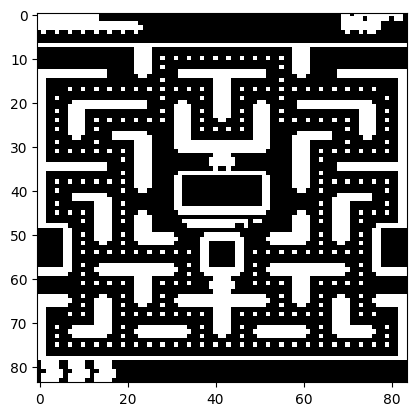

In [22]:
# Test Code
env_pacman = PacmanEnvWrapper(env, k=4, img_size=(84,84))
print("observation space:", env_pacman.observation_space.shape)

state = env_pacman.reset()
action = env_pacman.action_space.sample()
obs, reward, terminated, info = env_pacman.step(action)
print(obs)
plt.imshow(obs[0], cmap="gray")

### 3.5 Test `PacmanEnvWrapper`
* Without DQN, test if it works

In [23]:

# env_name = "gymnasium_env/PacmanGymEnv"
# env = gym.make(env_name, speedup=4.0)
# env = env.unwrapped #減少限制

# print("environment:", env_name)
# print("action space:", env.action_space.n)
# print("action:", env.unwrapped.get_action_meanings())
# print("observation space:", env.observation_space.shape)
pacman_env = PacmanEnvWrapper(env, k=4, img_size=(84,84))
state = pacman_env.reset()
step = 0
total_reward = 0
while True:
    action = pacman_env.action_space.sample()
    obs, reward, terminated, info = pacman_env.step(action)
    step+=1
    total_reward += reward
    print('\rStep: {:3d} | Reward: {:.3f} / {:.3f} | Action: {:.3f} | Info: {}'.format(step, reward, total_reward, action, info), end="")
    
    # if step%40==0:
    #     # print(30)
    #     plt.figure()
    #     plt.imshow(obs[0],cmap="gray")
    #     plt.axis('off')  # 关闭坐标轴
    # print(f"state: {state[1]}")
    if terminated or step>10:
        break

Step:  11 | Reward: 149.000 / 517.000 | Action: 1.000 | Info: [{'lives': 3, 'total_score': 90}, {'lives': 3, 'total_score': 90}, {'lives': 3, 'total_score': 100}, {'lives': 3, 'total_score': 110}]

### 4. Output to GIF
* remember to run it, it'll be used later.

In [24]:
project_root = os.getcwd()
def save_gif(img_buffer, fname, gif_path=os.path.join(project_root, "GIF")):
    if not os.path.exists(gif_path):
        os.makedirs(gif_path)
    img_buffer[0].save(os.path.join(gif_path, fname), save_all=True, append_images=img_buffer[1:], duration=3, loop=0)

# Implement DQN

### 5.1 Define QNet

In [26]:

class QNet(nn.Module):
    # TODO(Lab-4): Q-Network architecture.
    def __init__(self, input_shape, n_actions):
        super(QNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        conv_out_size = self._get_conv_out(input_shape)

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions),
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x)
        out = self.fc(conv_out)
        return out

In [ ]:
class DuelingQNet(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DuelingQNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        conv_out_size = self._get_conv_out(input_shape)

        # Value stream
        self.value_stream = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)  # Output a single value V(s)
        )

        # Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)  # Output advantages A(s, a)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x)
        value = self.value_stream(conv_out)
        advantage = self.advantage_stream(conv_out)

        # Combine value and advantage to get Q-values
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

### 5.2 Define DQN

In [29]:
class DeepQNetwork():
    def __init__(
        self,
        n_actions,
        input_shape,
        qnet,
        device,
        learning_rate=2e-4,
        reward_decay=0.99,
        replace_target_iter=1000,
        memory_size=10000,
        batch_size=32,
    ):
        # initialize parameters
        self.n_actions = n_actions
        self.input_shape = input_shape
        self.lr = learning_rate
        self.gamma = reward_decay
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.device = device
        self.learn_step_counter = 0
        self.init_memory()

        # Network
        self.qnet_eval = qnet(self.input_shape, self.n_actions).to(self.device)
        self.qnet_target = qnet(self.input_shape, self.n_actions).to(self.device)
        self.qnet_target.eval()
        self.optimizer = optim.RMSprop(self.qnet_eval.parameters(), lr=self.lr)

    def choose_action(self, state, epsilon=0):
        # 將狀態轉換為 FloatTensor 並增加 batch 維度
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        actions_value = self.qnet_eval.forward(state)
        if np.random.uniform() > epsilon:  # greedy
            action = torch.max(actions_value, 1)[1].data.cpu().numpy()[0]
        else:  # random
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        # 替换目标网络参数
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.qnet_target.load_state_dict(self.qnet_eval.state_dict())

        # 随机采样经验池中的一个批次
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)

        b_s = torch.FloatTensor(self.memory["s"][sample_index]).to(self.device)
        b_a = torch.LongTensor(self.memory["a"][sample_index]).to(self.device)
        b_r = torch.FloatTensor(self.memory["r"][sample_index]).to(self.device)
        b_s_ = torch.FloatTensor(self.memory["s_"][sample_index]).to(self.device)
        b_d = torch.FloatTensor(self.memory["done"][sample_index]).to(self.device)

        # DQN 和 DDQN 两种方式
        q_curr_eval = self.qnet_eval(b_s).gather(1, b_a)
        q_next_target = self.qnet_target(b_s_).detach()
        q_next_eval = self.qnet_eval(b_s_).detach()
        next_state_values = q_next_target.gather(1, q_next_eval.max(1)[1].unsqueeze(1))  # DDQN
        q_curr_recur = b_r + (1 - b_d) * self.gamma * next_state_values

        # 损失计算
        self.loss = F.smooth_l1_loss(q_curr_eval, q_curr_recur)

        # 反向传播和优化
        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()
        self.learn_step_counter += 1

        return self.loss.detach().cpu().numpy()



    def init_memory(self):
        # 初始化经验池
        self.memory = {
            "s": np.zeros((self.memory_size, *self.input_shape)),
            "a": np.zeros((self.memory_size, 1)),
            "r": np.zeros((self.memory_size, 1)),
            "s_": np.zeros((self.memory_size, *self.input_shape)),
            "done": np.zeros((self.memory_size, 1)),
        }

    def store_transition(self, s, a, r, s_, d):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
        index = self.memory_counter % self.memory_size
        self.memory["s"][index] = s
        self.memory["a"][index] = np.array(a).reshape(-1, 1)
        self.memory["r"][index] = np.array(r).reshape(-1, 1)
        self.memory["s_"][index] = s_
        self.memory["done"][index] = np.array(d).reshape(-1, 1)
        self.memory_counter += 1

    def save_load_model(self, op, path="save", fname="qnet.pt"):
        if not os.path.exists(path):
            os.makedirs(path)
        file_path = os.path.join(path, fname)

        if op == "save":
            # 保存模型狀態、優化器狀態、學習步驟和經驗池計數
            checkpoint = {
                'qnet_eval_state_dict': self.qnet_eval.state_dict(),
                'qnet_target_state_dict': self.qnet_target.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'learn_step_counter': self.learn_step_counter,
                'memory_counter': self.memory_counter,
            }
            torch.save(checkpoint, file_path)
            print(f"Model saved successfully at {file_path}")

        elif op == "load":
            try:
                # 加載模型狀態、優化器狀態、學習步驟和經驗池計數
                checkpoint = torch.load(file_path, map_location=self.device)

                # 檢查是否包含所有必需的鍵
                required_keys = ['qnet_eval_state_dict', 'qnet_target_state_dict', 'optimizer_state_dict']
                missing_keys = [key for key in required_keys if key not in checkpoint]

                if missing_keys:
                    raise KeyError(f"Missing keys in checkpoint: {missing_keys}")

                # 加載各部分的狀態
                self.qnet_eval.load_state_dict(checkpoint['qnet_eval_state_dict'])
                self.qnet_target.load_state_dict(checkpoint['qnet_target_state_dict'])
                self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

                # 選擇性地加載學習計數
                self.learn_step_counter = checkpoint.get('learn_step_counter', 0)
                self.memory_counter = checkpoint.get('memory_counter', 0)

                print("Model loaded successfully from", file_path)
                return {'learn_step_counter': self.learn_step_counter, 'memory_counter': self.memory_counter}

            except FileNotFoundError:
                print(f"No saved model found at {file_path}, starting fresh.")
            except KeyError as e:
                print(f"Error loading model: {e}")

        # 如果未成功加載模型或發生錯誤，返回初始狀態
        return {'learn_step_counter': 0, 'memory_counter': 0}



### 5.3 Define Epsilon Function

In [30]:
def epsilon_compute(frame_id, epsilon_max=1, epsilon_min=0.05, epsilon_decay=100000):
    return epsilon_min + (epsilon_max - epsilon_min) * np.exp(-frame_id / epsilon_decay)

* Graph of epsilon(0) to epsilon(400000)

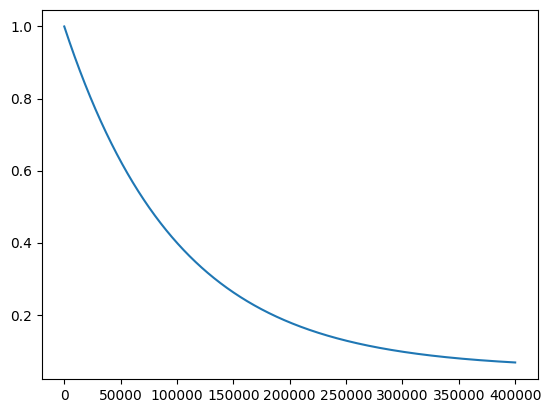

In [31]:
# Test Code
frame_ids = np.array(range(400000))
epsilons = epsilon_compute(frame_ids)
plt.plot(epsilons)

### 6. Initialize DQN

In [34]:
stack_frames = 4
img_size = (84,84)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

agent = DeepQNetwork(
        n_actions = env.action_space.n,
        input_shape = [stack_frames, *img_size],
        # qnet = QNet,
        qnet = DuelingQNet,
        device = device,
        learning_rate = 2e-5,
        reward_decay = 0.95,
        replace_target_iter = 1000,
        memory_size = 10000,
        batch_size = 32,)

print(agent.qnet_eval)

DuelingQNet(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (value_stream): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
  (advantage_stream): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=5, bias=True)
  )
)


### 7. Define `Play()`

In [ ]:

import gymnasium as gym
import gymnasium_env
def play(env, agent, stack_frames, img_size):
    # Reset environment.
    state = env.reset()
    img_buffer = [Image.fromarray(state[0]*255)]

    # Initialize information.
    step = 0
    total_reward = 0

    # One episode.
    while True:
        # Select action.
        action = agent.choose_action(state, 0)

        # Get next stacked state.
        state_next, reward, done, info = env.step(action)
        if step % 2 == 0:
            img_buffer.append(Image.fromarray(state_next[0]*255))

        state = state_next.copy()
        step += 1
        total_reward += reward
        print('\rStep: {:3d} | Reward: {:.3f} / {:.3f} | Action: {:.3f} | Info: {}'.format(step, reward, total_reward, action, info[0]), end="")

        if done or step>1000:
            print()
            break

    return img_buffer


### 8. Test play

* Test play() function, *you don't need to run it if you did not change it*.

In [38]:
env_pacman = PacmanEnvWrapper(env, k=4, img_size=(84,84))
img_buffer = play(env_pacman, agent, stack_frames, img_size)
save_gif(img_buffer, fname="test0.gif")

Step: 167 | Reward: -100.000 / 3699.000 | Action: 3.000 | Info: {'lives': 0, 'total_score': 1180}


# Start Training

### 9. Define `train()`

In [ ]:
def train(env, agent, stack_frames, img_size, save_path="save", max_steps=1000000):
    total_step = 0
    episode = 0

        # 嘗試加載模型和訓練狀態
    try:
        print("Loading model and training status...")
        status = agent.save_load_model(op="load", path=save_path, fname="qnet.pt")
        total_step = status["learn_step_counter"]
        episode = status["memory_counter"]
        print(f"Resuming training from total_step={total_step}, episode={episode}")
    except FileNotFoundError:
        print("No previous model found. Starting training from scratch.")
    except KeyError as e:
        print(f"Missing key in checkpoint: {e}")


    while total_step <= max_steps:
        # Reset environment.
        state = env.reset()

        # 如果 state 是 tuple，提取圖像
        if isinstance(state, tuple):
            state = state[0]

        # Initialize information.
        step = 0
        total_reward = 0
        loss = 0

        # One episode.
        while True:
            # TODO(Lab-6): Select action.
            epsilon = epsilon_compute(total_step)
            action = agent.choose_action(state, epsilon)

            # Get next observation.
            obs, reward, terminated, info = env.step(action)

            # 如果 obs 是 tuple，提取圖像
            if isinstance(obs, tuple):
                obs = obs[0]

            # 判斷是否遊戲結束
            done = terminated

            # TODO(Lab-7): Train RL model.
            # Store transition and learn.
            agent.store_transition(state, action, reward, obs, done)
            if total_step > 4 * agent.batch_size:
                loss = agent.learn()

            state = obs.copy()  # 更新狀態
            step += 1
            total_step += 1
            total_reward += reward

            # 確保 loss 為浮點數以便於打印
            if total_step % 10 == 0 or done:
                print('\rEpisode: {:3d} | Step: {:3d} / {:3d} | Reward: {:.3f} / {:.3f} | Loss: {:.3f} | Epsilon: {:.3f}'\
                    .format(episode, step, total_step, reward, total_reward, loss, epsilon), end="")

            if total_step % 1000 == 0:
                print("\nSave Model ...")
                agent.save_load_model(
                    op="save",
                    path=save_path,
                    fname="qnet.pt"
                )
                print("Generate GIF ...")
                img_buffer = play(env, agent, stack_frames, img_size)
                save_gif(img_buffer, "train_" + str(total_step).zfill(6) + ".gif")
                print("Done !!")

            if done or step > 1000:
                episode += 1
                print()
                break

        if total_step > max_steps:
            break


### 10. Train the model

* 600step/min on Colab (with T4 GPU), 400step/min on RTX3070 laptop. Pretty slow

In [ ]:
env_pacman = PacmanEnvWrapper(env, k=4, img_size=(84,84))
train(env_pacman, agent, stack_frames, img_size, save_path=os.path.join(project_root, "save"), max_steps=600000)

Loading model and training status...
Model loaded successfully from c:\Users\howar\Code_on_win\Gym\latest\Pacman-RL-environment\save\qnet.pt
Resuming training from total_step=1205, episode=1463


C:\Users\howar\AppData\Local\Temp\ipykernel_29384\2425402526.py:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path, map_location=self.devic

Episode: 1463 | Step:  98 / 1303 | Reward: -102.000 / 3146.000 | Loss: 6.361 | Epsilon: 0.988
Episode: 1464 | Step:  71 / 1374 | Reward: -100.000 / 1564.000 | Loss: 0.240 | Epsilon: 0.987
Episode: 1465 | Step: 106 / 1480 | Reward: -100.000 / 3585.000 | Loss: 1.530 | Epsilon: 0.986
Episode: 1466 | Step:  82 / 1562 | Reward: -100.000 / 1877.000 | Loss: 0.275 | Epsilon: 0.985
Episode: 1467 | Step:  69 / 1631 | Reward: -102.000 / 346.000 | Loss: 10.872 | Epsilon: 0.985
Episode: 1468 | Step: 105 / 1736 | Reward: -100.000 / 2458.000 | Loss: 9.510 | Epsilon: 0.984
Episode: 1469 | Step:  96 / 1832 | Reward: -52.000 / 3011.000 | Loss: 24.047 | Epsilon: 0.983
Episode: 1470 | Step: 112 / 1944 | Reward: -100.000 / 2073.000 | Loss: 23.352 | Epsilon: 0.982
Episode: 1471 | Step:  56 / 2000 | Reward: -4.000 / -14.000 | Loss: 14.246 | Epsilon: 0.98181
Save Model ...
Model saved successfully at c:\Users\howar\Code_on_win\Gym\latest\Pacman-RL-environment\save\qnet.pt
Generate GIF ...
Step: 134 | Reward: 

# Evaluate Model

In [18]:
agent.save_load_model(op="load", path=os.path.join(project_root, "save"), fname="qnet.pt")
env_pacman = PacmanEnvWrapper(env, k=4, img_size=(84,84))
img_buffer = play(env_pacman, agent, stack_frames, img_size)
save_gif(img_buffer, "eval.gif")

C:\Users\howar\AppData\Local\Temp\ipykernel_29384\2425402526.py:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path, map_location=self.devic

Model loaded successfully from c:\Users\howar\Code_on_win\Gym\latest\Pacman-RL-environment\save\qnet.pt
Step:  49 | Reward: -102.000 / 171.000 | Action: 0.000 | Info: {'lives': 1, 'total_score': 130}


# Old Codes
* Would probably be useful later or really just junks

### Step 1.
* This is to test `PacmanGymEnv` could run by itself.

In [ ]:

# import gymnasium_env
# import gymnasium
# import warnings
# from PIL import Image
# import numpy as np
# import os

# # 設定無視窗模式
# os.environ["SDL_VIDEODRIVER"] = "dummy"

# # 忽略 DeprecationWarning
# warnings.filterwarnings("ignore", category=DeprecationWarning)

# # 初始化環境
# env = gymnasium.make('gymnasium_env/PacmanGymEnv', speedup=4.0)
# obs, info = env.reset()
# env_unwrapped = env.unwrapped   

# # 用來保存每一幀的圖像
# frames = []

# # 設定最多 1000 步
# for step in range(1000):
#     action = env.action_space.sample()  # 隨機取樣一個動作
#     obs, reward, done, info = env.step(action)
    
    
#     # 確保返回值非空並且是 numpy array 格式
#     if obs is not None and isinstance(obs, np.ndarray):
#         img = Image.fromarray(obs)  # 轉換為 PIL 圖像格式
#         frames.append(img)  # 添加幀到 frames 列表中
#     else:
#         print("Render did not return a valid image.")
    
#     print(f"Step: {step + 1}, Action: {action}, Reward: {reward}, Info: {info}, Done: {done}")

#     # 檢查是否回合結束
#     if done:
#         print("Episode finished!")
#         break

# # 關閉環境
# env.close()

# # 保存為 GIF
# output_path = "../Gif/pacman_game.gif"
# frames[0].save(output_path, save_all=True, append_images=frames[1:], duration=100, loop=1)
# print(f"GIF saved as {output_path}")

### Step 5.
* Old implementation of `play()`

In [ ]:
# def play(env, agent, stack_frames, img_size):
#     #os.environ["SDL_VIDEODRIVER"] = "dummy"
#     # Reset environment.
#     state = env.reset()

#     # 如果state是tuple，提取第一個元素作為圖像
#     if isinstance(state, tuple):
#         state = state[0]

#     # state形狀應該是 (k, 84, 84)，所以不再提取單幀
#     # 確保數據類型為uint8，並去除不必要的維度
#     state = (state * 255).astype(np.uint8)

#     # 初始化圖像緩衝區
#     img_buffer = [Image.fromarray(state[0])]  # 顯示第一幀

#     # Initialize information.
#     step = 0
#     total_reward = 0

#     # One episode.
#     while True:
#         # Select action.
#         action = agent.choose_action(state, 0)

#         # Get next stacked state.
#         state_next, reward, terminated, info = env.step(action)

#         # 如果 state_next 是 tuple，提取圖像
#         if isinstance(state_next, tuple):
#             state_next = state_next[0]

#         # 不再提取單幀，直接使用多幀數據
#         state_next = (state_next * 255).astype(np.uint8)

#         # 每兩步存儲一幀圖像
#         if step % 2 == 0:
#             img_buffer.append(Image.fromarray(state_next[0]))  # 顯示第一幀

#         state = state_next.copy()  # 更新狀態
#         step += 1
#         total_reward += reward
#         print('\rStep: {:3d} | Reward: {:.3f} / {:.3f} | Action: {:.3f} | Info: {}'.format(step, reward, total_reward, action, info[0]), end="")


#         # 檢查遊戲是否結束或步數超過2000
#         if terminated  or step > 400:
#             print()
#             break

#     return img_buffer

### Step 5.2
* Old implementation of learn()

### Step 9.
* This piece of code attempted to load model but failed.

In [ ]:
    # 嘗試加載模型和訓練狀態
    # try:
    #     print("Loading model and training status...")
    #     status = agent.save_load_model(op="load", path=save_path, fname="qnet.pt")
    #     total_step = status["learn_step_counter"]
    #     episode = status["memory_counter"]
    #     print(f"Resuming training from total_step={total_step}, episode={episode}")
    # except FileNotFoundError:
    #     print("No previous model found. Starting training from scratch.")
    # except KeyError as e:
    #     print(f"Missing key in checkpoint: {e}")

    # try:
    #     print("Loading model and training status...")
    #     status = agent.save_load_model(op="load", path=save_path, fname="qnet.pt")
    #     total_step = status.get("total_step", 0)
    #     episode = status.get("episode", 0)
    #     print(f"Resuming training from total_step={total_step}, episode={episode}")
    # except FileNotFoundError:
    #     print("No previous model found. Starting training from scratch.")

    # def save_load_model(self, op, path="save", fname="qnet.pt"):
    #     import os
    #     if not os.path.exists(path):
    #         os.makedirs(path)
    #     file_path = os.path.join(path, fname)

    #     if op == "save":
    #         # 保存模型狀態、優化器狀態、學習步驟和經驗池計數
    #         checkpoint = {
    #             'qnet_eval_state_dict': self.qnet_eval.state_dict(),
    #             'qnet_target_state_dict': self.qnet_target.state_dict(),
    #             'optimizer_state_dict': self.optimizer.state_dict(),
    #             'learn_step_counter': self.learn_step_counter,
    #             'memory_counter': self.memory_counter,
    #         }
    #         torch.save(checkpoint, file_path)

    #     elif op == "load":
    #         # 加載模型狀態、優化器狀態、學習步驟和經驗池計數
    #         checkpoint = torch.load(file_path, map_location=self.device)
    #         self.qnet_eval.load_state_dict(checkpoint['qnet_eval_state_dict'])
    #         self.qnet_target.load_state_dict(checkpoint['qnet_target_state_dict'])
    #         self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #         self.learn_step_counter = checkpoint.get('learn_step_counter', -1)
    #         self.memory_counter = checkpoint.get('memory_counter', -1)
